# Load DataSet

In [1]:
import numpy as np

!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
data = np.load('Data.npz')
print(data.files)

--2022-01-12 15:59:11--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  5.38MB/s    in 3.5s    

2022-01-12 15:59:17 (5.38 MB/s) - ‘Data.npz’ saved [19725078/19725078]

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


# Visualization

In [2]:
import numpy as np

x_train = data['train_images']
y_train = data['train_labels']

x_val = data['val_images']
y_val = data['val_labels']

x_test = data['test_images']
y_test = data['test_labels']

print('Labels: ', np.unique(y_train))
labels_number = len(np.unique(y_train))

print('train_images shape: ', data['train_images'].shape)
print('train_labels shape: ', data['train_labels'].shape)

print('val_images shape: ', data['val_images'].shape)
print('val_labels shape: ', data['val_labels'].shape)

print('test_images shape: ', data['test_images'].shape)
print('test_labels shape: ', data['test_labels'].shape)

Labels:  [0 1 2 3 4 5 6]
train_images shape:  (7007, 28, 28, 3)
train_labels shape:  (7007, 1)
val_images shape:  (1003, 28, 28, 3)
val_labels shape:  (1003, 1)
test_images shape:  (2005, 28, 28, 3)
test_labels shape:  (2005, 1)


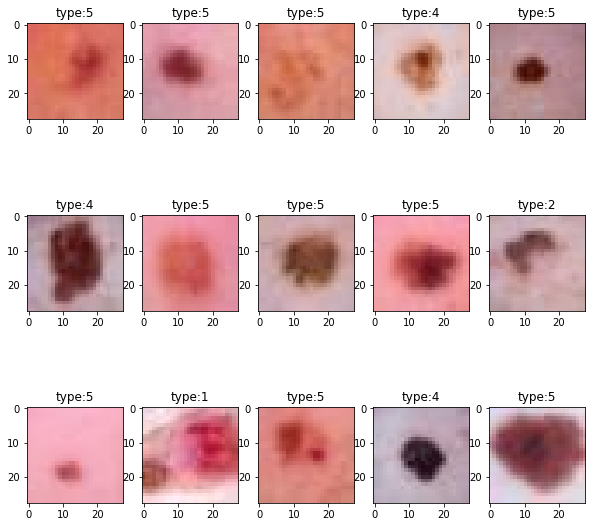

In [3]:
def plot_img(x_train, y_train):
    from matplotlib import pyplot as plt
    fig=plt.figure(figsize=(10, 10))
    columns = 5
    rows = 3
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        img = x_train[i]
        plt.imshow(img)
        plt.title('type:'+str(y_train[i][0]))
    plt.show()
plot_img(x_train, y_train)

# Unbalancment of data 

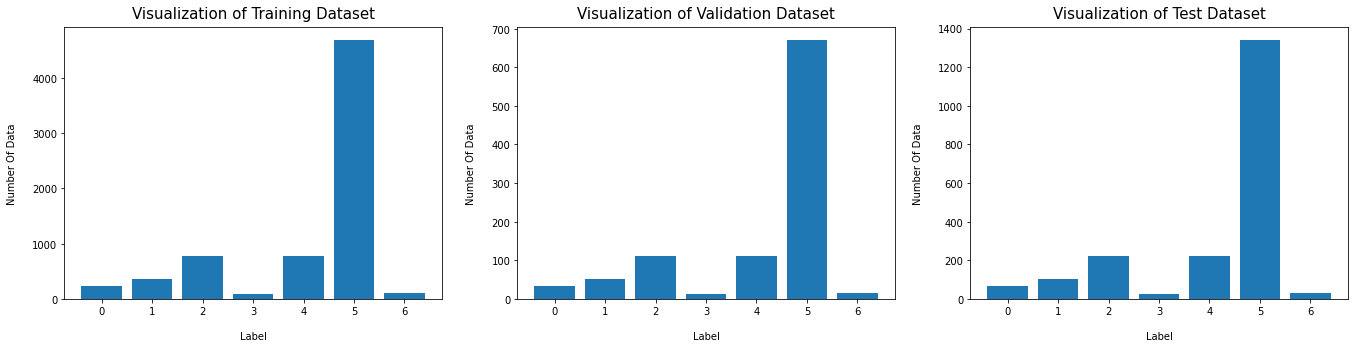

In [4]:
from matplotlib import pyplot as plt

def data_summary(y):
    data = dict()
    for i in range(labels_number):
        data[str(i)] = (int)(np.sum(y==i))
    group_data = list(data.values())
    group_names = list(data.keys())
    return group_data, group_names

def draw_ax(i, group_data, group_names, title):
    ax[i].bar(group_names, group_data)
    ax[i].set_title("Visualization of "+ title , y=1.01, fontsize=15)
    ax[i].set_ylabel("Number Of Data", labelpad=15)
    ax[i].set_xlabel("Label", labelpad=15)

fig, ax = plt.subplots(1, 3, figsize=(23, 5))

group_data, group_names = data_summary(y_train)
draw_ax(0, group_data, group_names, "Training Dataset")

group_data, group_names = data_summary(y_val)
draw_ax(1, group_data, group_names, "Validation Dataset")

group_data, group_names = data_summary(y_test)
draw_ax(2, group_data, group_names, "Test Dataset")

# Hyperparameters

In [5]:
import math
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Add, Flatten, Activation
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [6]:
INPUT_SHAPE = (28, 28, 3)
N_CLASSES = 7
DEPTH = 11
EPOCHS = 20
BATCH_SIZE = 32

# Preprocess

In [7]:
y_train = to_categorical(y_train, N_CLASSES)
y_val = to_categorical(y_val, N_CLASSES)
y_test = to_categorical(y_test, N_CLASSES)

In [8]:
datagen = ImageDataGenerator(rescale=1./255)

train_set = datagen.flow(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_set = datagen.flow(
    x=x_val,
    y=y_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_set = datagen.flow(
    x=x_test,
    y=y_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Model && Training

In [9]:
def resnet_layer(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation='relu',
    batch_normalization=True,
    conv_first=True
):

    conv = Conv2D(
        num_filters,
        kernel_size,
        strides,
        padding='same',
        kernel_initializer='he_normal',
        kernel_regularizer=l2(1e-4),
    )

    x = inputs

    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)

    return x

In [10]:
def model_structure(input_shape, depth, num_classes):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')

    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs, num_filters=num_filters_in)

    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:
                    strides = 2


            y = resnet_layer(
                inputs=x,
                num_filters=num_filters_in,
                kernel_size=1,
                strides=strides,
                activation=activation,
                batch_normalization=batch_normalization,
                conv_first=False,
            )

            y = resnet_layer(
                inputs=y,
                num_filters=num_filters_in,
                conv_first=False
            )

            y = resnet_layer(
                inputs=y,
                num_filters=num_filters_out,
                kernel_size=1,
                conv_first=False
            )

            if res_block == 0:
                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters_out,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )

            x = Add()([x, y])

        num_filters_in = num_filters_out

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    y = Flatten()(x)

    outputs = Dense(
        num_classes,
        activation='softmax',
        kernel_initializer='he_normal'
    )(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
model = model_structure(
    input_shape=INPUT_SHAPE,
    depth=DEPTH,
    num_classes=N_CLASSES
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 28, 28, 16)   0           ['batch_normalization[0][0]']

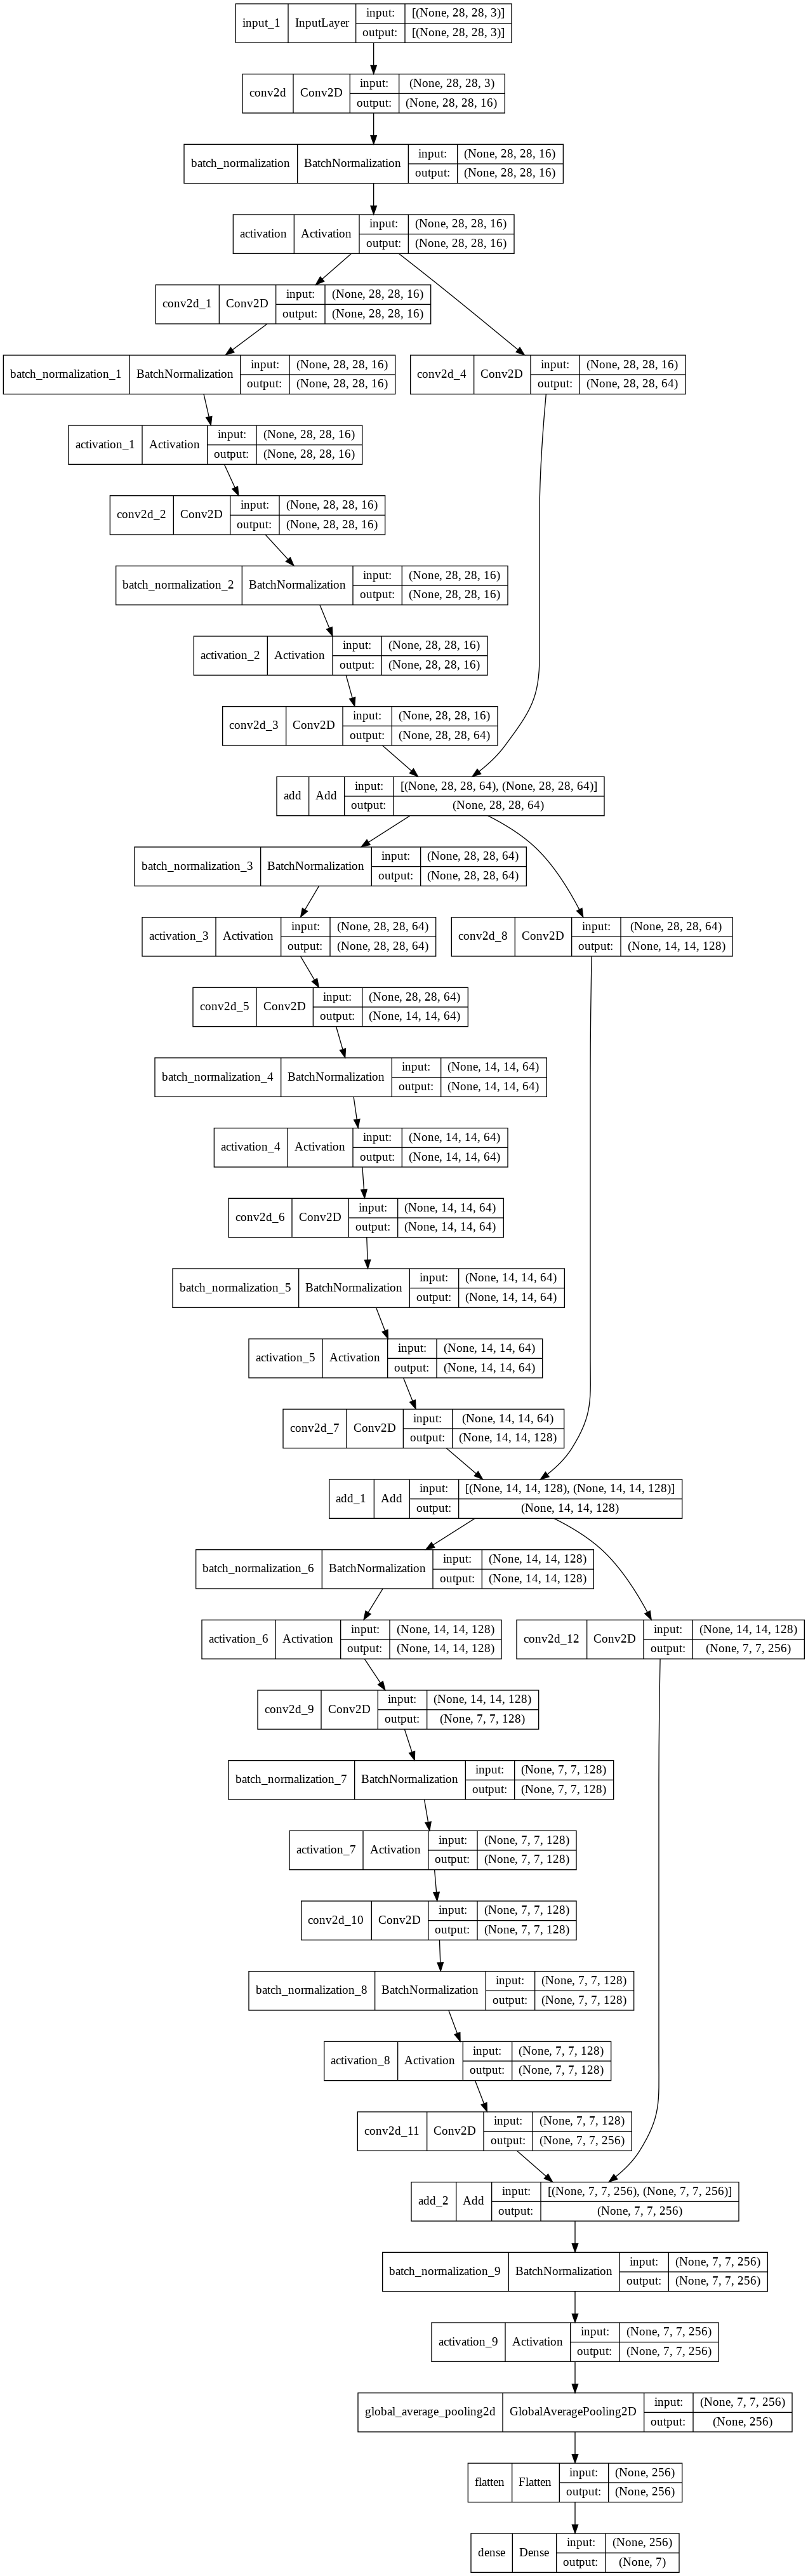

In [12]:
plot_model(
    model,
    to_file='model_structure.png',
    show_shapes=True,
    show_layer_names=True
)

In [13]:
history = model.fit(
    x=train_set,
    epochs=EPOCHS,
    validation_data=val_set,
)

Epoch 1/20
219/219 [==============================] - 21s 38ms/step - loss: 1.1554 - accuracy: 0.6726 - val_loss: 1.7127 - val_accuracy: 0.4855
Epoch 2/20
219/219 [==============================] - 8s 35ms/step - loss: 1.0319 - accuracy: 0.7040 - val_loss: 1.0762 - val_accuracy: 0.6889
Epoch 3/20
219/219 [==============================] - 8s 35ms/step - loss: 0.9645 - accuracy: 0.7180 - val_loss: 1.0990 - val_accuracy: 0.6590
Epoch 4/20
219/219 [==============================] - 8s 35ms/step - loss: 0.9278 - accuracy: 0.7238 - val_loss: 0.9593 - val_accuracy: 0.7228
Epoch 5/20
219/219 [==============================] - 8s 35ms/step - loss: 0.8790 - accuracy: 0.7407 - val_loss: 1.4747 - val_accuracy: 0.5105
Epoch 6/20
219/219 [==============================] - 8s 35ms/step - loss: 0.8587 - accuracy: 0.7430 - val_loss: 0.9709 - val_accuracy: 0.7258
Epoch 7/20
219/219 [==============================] - 8s 35ms/step - loss: 0.8285 - accuracy: 0.7511 - val_loss: 0.8560 - val_accuracy: 0.756

In [14]:
test_loss, test_acc = model.evaluate(test_set)
print('Test loss = {:.2f} , Test accuracy = {:.2f}'.format(test_loss, test_acc*100))

63/63 [==============================] - 1s 11ms/step - loss: 1.6665 - accuracy: 0.6918
Test loss = 1.67 , Test accuracy = 69.18


# Plot results
Classification Report (F1, Recall, Precision)

Confusion Matrix

Area Under Curve

In [15]:
def plot_results(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.tight_layout(pad=4)

    ax1.set_title('Accuracy')
    ax1.plot(acc)
    ax1.plot(val_acc)
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['training', 'validation'], loc='lower right')

    ax2.set_title('Loss')
    ax2.plot(loss)
    ax2.plot(val_loss)
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['training', 'validation'], loc='upper right')

    fig.show()

In [16]:
def get_reports(data, model, mode):
    x = data[0] / 255.0
    y = data[1]
    target_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6']

    y_pred = model.predict(x)

    y = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    cr = classification_report(
        y,
        y_pred,
        target_names=target_names,
    )

    cm = confusion_matrix(y, y_pred)

    print(f'Classification Report {mode}')
    print(cr)

    print(f'Confusion Matrix {mode}')
    print(cm)

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest')
    plt.colorbar()
    tick_mark = np.arange(len(target_names))
    _ = plt.xticks(tick_mark, target_names, rotation=90)
    _ = plt.yticks(tick_mark, target_names)

In [17]:
def plot_auc(data, model, mode):
    x = data[0] / 255.0
    target_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6']
    n_classes = len(target_names)

    y = data[1]
    y_pred = model.predict(x)

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y.ravel(), y_pred.ravel()
    )
    average_precision["micro"] = average_precision_score(y, y_pred, average="micro")

    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal", "red", "blue"])
    _, ax = plt.subplots(figsize=(10, 8))

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f'AUC for class {i}', color=color)

    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")
    
    plt.show()

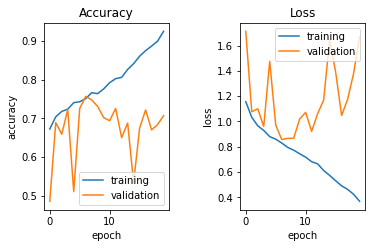

In [18]:
plot_results(
    acc=history.history["accuracy"],
    val_acc=history.history["val_accuracy"],
    loss=history.history["loss"],
    val_loss=history.history["val_loss"],
)

Classification Report Train
              precision    recall  f1-score   support

          c0       0.85      0.15      0.25       228
          c1       0.83      0.29      0.43       359
          c2       0.54      0.85      0.66       769
          c3       0.29      0.19      0.23        80
          c4       0.96      0.14      0.24       779
          c5       0.84      0.96      0.90      4693
          c6       0.87      0.84      0.86        99

    accuracy                           0.79      7007
   macro avg       0.74      0.49      0.51      7007
weighted avg       0.81      0.79      0.74      7007

Confusion Matrix Train
[[  34   13  119    5    0   57    0]
 [   3  105   84   27    2  130    8]
 [   0    1  654    2    0  112    0]
 [   0    4   30   15    0   31    0]
 [   2    0  145    0  106  523    3]
 [   1    2  175    3    2 4509    1]
 [   0    1    0    0    0   15   83]]


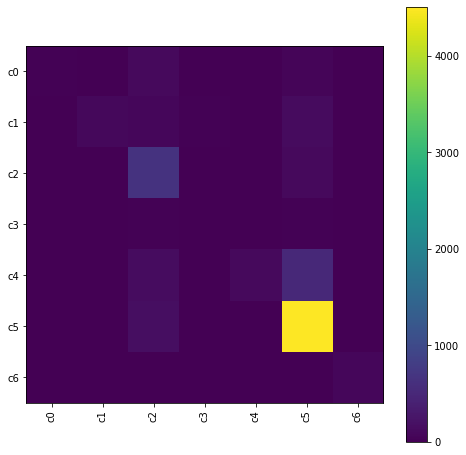

In [19]:
get_reports([x_train, y_train], model=model, mode='Train')

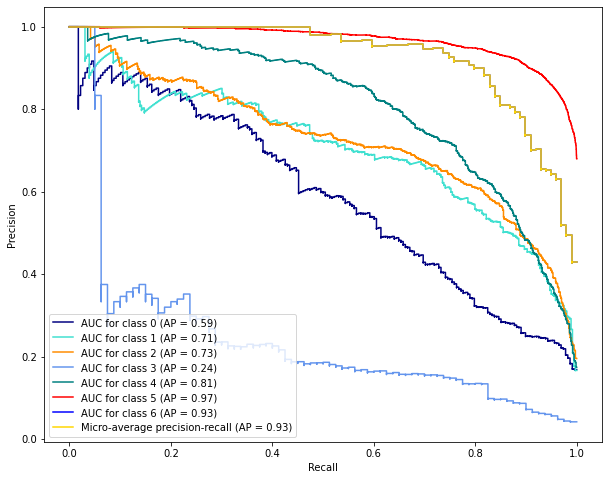

In [20]:
plot_auc([x_train, y_train], model=model, mode='Train')

Classification Report Validation
              precision    recall  f1-score   support

          c0       0.50      0.03      0.06        33
          c1       0.27      0.08      0.12        52
          c2       0.38      0.55      0.45       110
          c3       0.30      0.25      0.27        12
          c4       0.70      0.06      0.12       111
          c5       0.78      0.93      0.85       671
          c6       0.78      0.50      0.61        14

    accuracy                           0.71      1003
   macro avg       0.53      0.34      0.35      1003
weighted avg       0.69      0.71      0.65      1003

Confusion Matrix Validation
[[  1   3  18   0   0  11   0]
 [  0   4  16   4   0  28   0]
 [  1   2  60   2   0  45   0]
 [  0   3   4   3   0   2   0]
 [  0   0  19   0   7  85   0]
 [  0   1  38   1   2 627   2]
 [  0   2   1   0   1   3   7]]


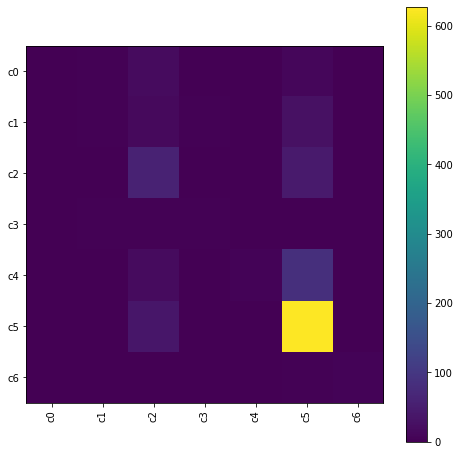

In [21]:
get_reports([x_val, y_val], model=model, mode='Validation')

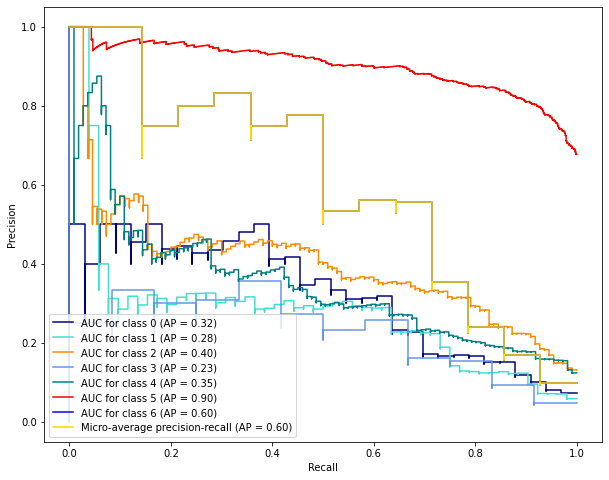

In [22]:
plot_auc([x_val, y_val], model=model, mode='Validation')

Classification Report Test
              precision    recall  f1-score   support

          c0       0.54      0.11      0.18        66
          c1       0.38      0.09      0.14       103
          c2       0.34      0.50      0.40       220
          c3       0.00      0.00      0.00        23
          c4       0.70      0.06      0.12       223
          c5       0.77      0.92      0.84      1341
          c6       0.76      0.55      0.64        29

    accuracy                           0.69      2005
   macro avg       0.50      0.32      0.33      2005
weighted avg       0.68      0.69      0.64      2005

Confusion Matrix Test
[[   7    5   28    0    0   25    1]
 [   2    9   42    4    0   44    2]
 [   2    2  109    0    4  103    0]
 [   1    2    6    0    0   14    0]
 [   1    0   37    0   14  169    2]
 [   0    4  101    2    2 1232    0]
 [   0    2    1    1    0    9   16]]


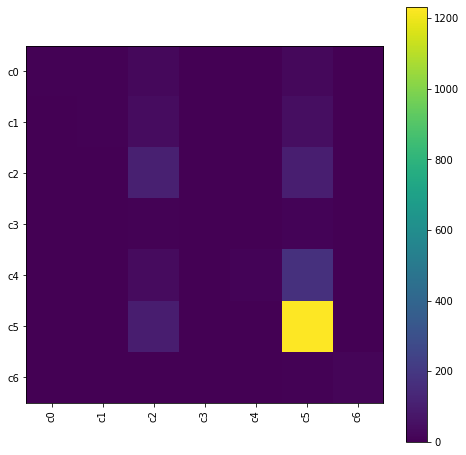

In [23]:
get_reports([x_test, y_test], model=model, mode='Test')

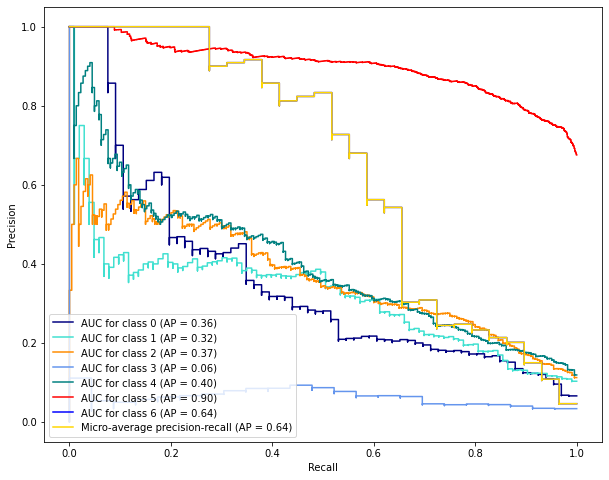

In [24]:
plot_auc([x_test, y_test], model=model, mode='Test')

# Bonus Part
Data Augmentation

In [25]:
augmented_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_set = augmented_datagen.flow(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_set = datagen.flow(
    x=x_val,
    y=y_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_set = datagen.flow(
    x=x_test,
    y=y_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [26]:
model = model_structure(
    input_shape=INPUT_SHAPE,
    depth=DEPTH,
    num_classes=N_CLASSES
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 28, 28, 16)   448         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 28, 28, 16)  64          ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_10 (Activation)     (None, 28, 28, 16)   0           ['batch_normalization_10[0]

In [27]:
history = model.fit(
    x=train_set,
    epochs=EPOCHS,
    validation_data=val_set,
)

Epoch 1/20
219/219 [==============================] - 11s 40ms/step - loss: 1.1521 - accuracy: 0.6778 - val_loss: 1.1907 - val_accuracy: 0.6311
Epoch 2/20
219/219 [==============================] - 9s 39ms/step - loss: 1.0512 - accuracy: 0.6957 - val_loss: 1.0526 - val_accuracy: 0.6909
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 0.9995 - accuracy: 0.7039 - val_loss: 1.0609 - val_accuracy: 0.6859
Epoch 4/20
219/219 [==============================] - 8s 38ms/step - loss: 0.9640 - accuracy: 0.7126 - val_loss: 1.0730 - val_accuracy: 0.6660
Epoch 5/20
219/219 [==============================] - 8s 38ms/step - loss: 0.9315 - accuracy: 0.7139 - val_loss: 0.9202 - val_accuracy: 0.7358
Epoch 6/20
219/219 [==============================] - 8s 38ms/step - loss: 0.9031 - accuracy: 0.7224 - val_loss: 1.0273 - val_accuracy: 0.6780
Epoch 7/20
219/219 [==============================] - 8s 38ms/step - loss: 0.8863 - accuracy: 0.7258 - val_loss: 1.0535 - val_accuracy: 0.669

In [28]:
test_loss, test_acc = model.evaluate(test_set)
print('Test loss = {:.2f} , Test accuracy = {:.2f}'.format(test_loss, test_acc*100))

63/63 [==============================] - 1s 9ms/step - loss: 1.0130 - accuracy: 0.6584
Test loss = 1.01 , Test accuracy = 65.84


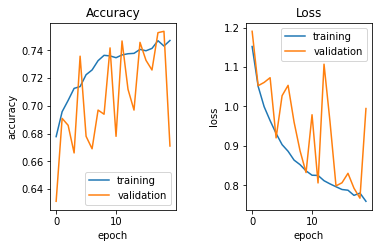

In [29]:
plot_results(
    acc=history.history["accuracy"],
    val_acc=history.history["val_accuracy"],
    loss=history.history["loss"],
    val_loss=history.history["val_loss"],
)

Classification Report Train
              precision    recall  f1-score   support

          c0       0.30      0.27      0.28       228
          c1       0.23      0.84      0.36       359
          c2       0.61      0.40      0.49       769
          c3       0.67      0.03      0.05        80
          c4       0.51      0.38      0.44       779
          c5       0.88      0.79      0.84      4693
          c6       0.45      0.78      0.57        99

    accuracy                           0.68      7007
   macro avg       0.52      0.50      0.43      7007
weighted avg       0.75      0.68      0.70      7007

Confusion Matrix Train
[[  61  144    7    0    8    8    0]
 [  13  302   11    0    8   18    7]
 [  39  179  310    0   67  170    4]
 [   3   63    5    2    1    6    0]
 [  44   74   56    0  298  297   10]
 [  45  524  120    1  201 3729   73]
 [   0   15    0    0    1    6   77]]


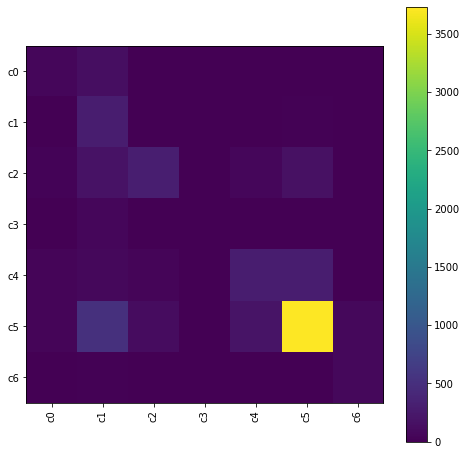

In [30]:
get_reports([x_train, y_train], model=model, mode='Train')

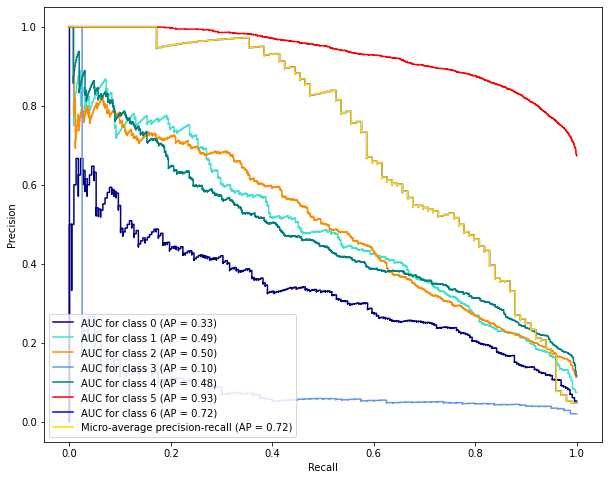

In [31]:
plot_auc([x_train, y_train], model=model, mode='Train')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report Validation
              precision    recall  f1-score   support

          c0       0.32      0.33      0.33        33
          c1       0.24      0.87      0.38        52
          c2       0.56      0.38      0.45       110
          c3       0.00      0.00      0.00        12
          c4       0.49      0.49      0.49       111
          c5       0.90      0.76      0.82       671
          c6       0.36      0.64      0.46        14

    accuracy                           0.67      1003
   macro avg       0.41      0.50      0.42      1003
weighted avg       0.74      0.67      0.69      1003

Confusion Matrix Validation
[[ 11  19   1   0   1   0   1]
 [  1  45   4   0   2   0   0]
 [  8  27  42   0  10  23   0]
 [  0  11   0   0   0   1   0]
 [  6   6   8   0  54  36   1]
 [  8  75  20   0  42 512  14]
 [  0   4   0   0   1   0   9]]


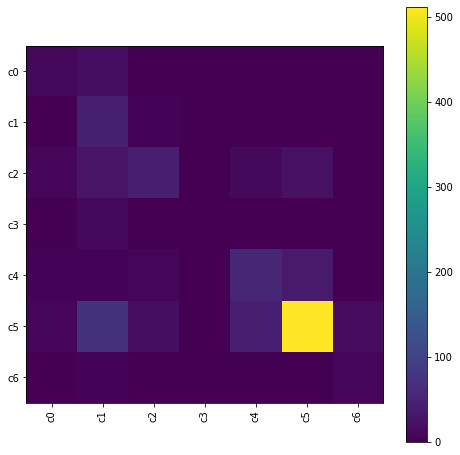

In [32]:
get_reports([x_val, y_val], model=model, mode='Validation')

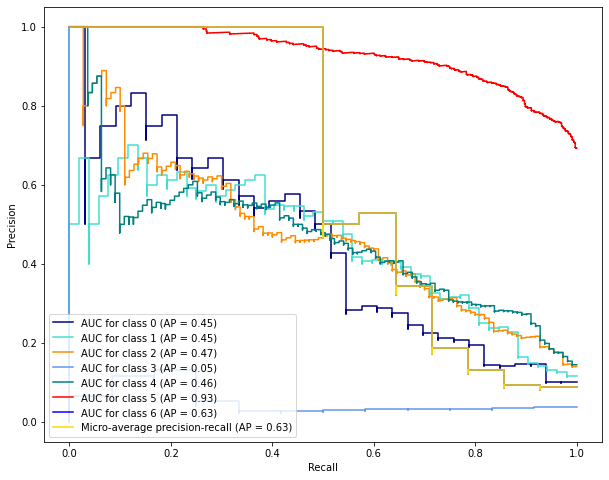

In [33]:
plot_auc([x_val, y_val], model=model, mode='Validation')

Classification Report Test
              precision    recall  f1-score   support

          c0       0.18      0.14      0.16        66
          c1       0.22      0.82      0.34       103
          c2       0.55      0.38      0.45       220
          c3       0.50      0.04      0.08        23
          c4       0.45      0.36      0.40       223
          c5       0.88      0.78      0.82      1341
          c6       0.43      0.72      0.54        29

    accuracy                           0.66      2005
   macro avg       0.46      0.46      0.40      2005
weighted avg       0.73      0.66      0.68      2005

Confusion Matrix Test
[[   9   49    3    0    3    1    1]
 [   4   84    3    0    2    5    5]
 [  13   56   83    0   23   45    0]
 [   0   17    1    1    1    3    0]
 [   6   25   20    0   81   87    4]
 [  17  155   40    1   69 1041   18]
 [   0    3    0    0    0    5   21]]


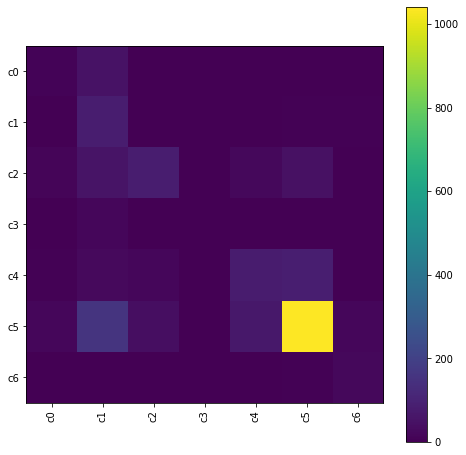

In [34]:
get_reports([x_test, y_test], model=model, mode='Test')

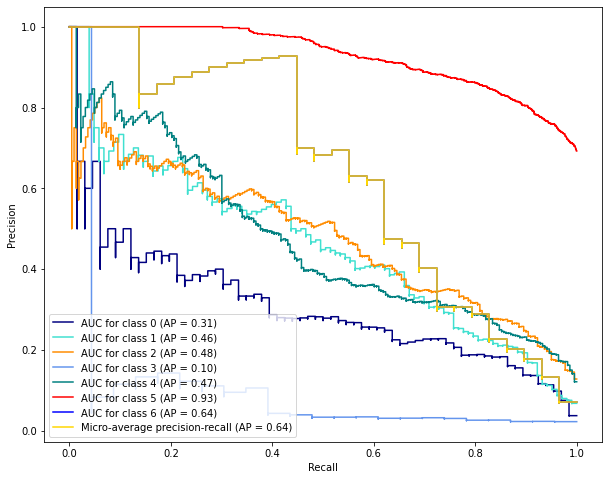

In [35]:
plot_auc([x_test, y_test], model=model, mode='Test')